In [1]:
import numpy as np
import numpy.random as npr
import math
from tqdm import tqdm
import io
import requests
import pandas as pd
import matplotlib.pyplot as plt

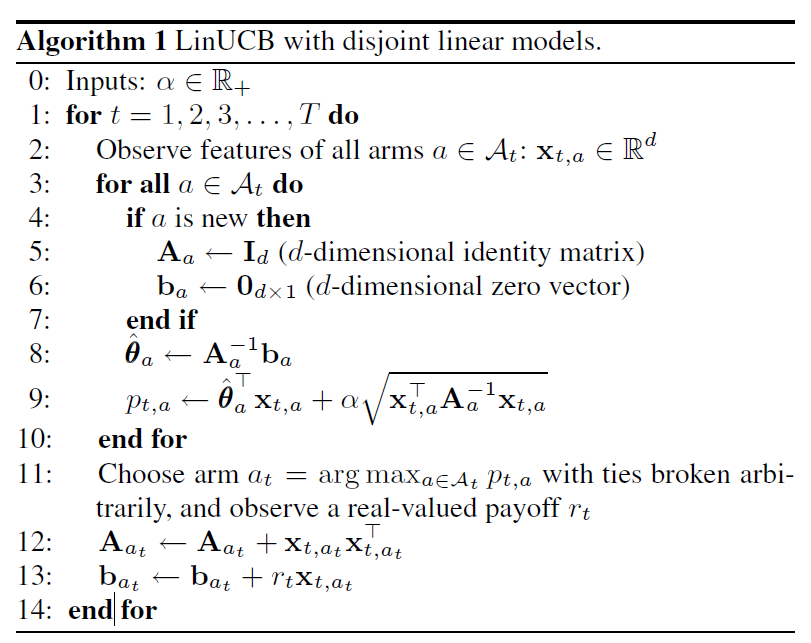

In [2]:
data = np.loadtxt(io.TextIOWrapper(io.BytesIO(requests.get('https://raw.githubusercontent.com/akhadangi/Multi-armed-Bandits/master/dataset.txt').content)))
arms = data[:,0].astype('int32') - 1 
rewards = data[:,1]

num_samples = len(arms)
num_arms = int(max(arms) + 1)

features = data[:,2:102].reshape(num_samples, num_arms, -1)
dim_feats = int(features.shape[-1])

nsteps = 800
alpha = 0.01  # the α in line 9, represents the weight of exploration term
A = np.array([np.eye(dim_feats, dtype='float32') for a in range(num_arms)]) 
b = np.array([np.zeros(dim_feats, dtype='float32') for a in range(num_arms)])

model_rewards = []
chosen_arms = []

t = 0
for arm, reward, feats in tqdm(zip(arms, rewards, features), total=num_samples):
    Ainv = np.linalg.inv(A)
    theta = np.array([_1 @ _2 for _1, _2 in zip(Ainv, b)]) # Line 8
    scores = np.array([theta[a].T @ feats[a] + alpha * np.sqrt(feats[a] @ Ainv[a] @ feats[a])
              for a in range(num_arms)])  # Line 9
    pred_arm = npr.choice(np.where(scores == max(scores))[0]) # Line 11
    chosen_arms.append(pred_arm)
    if pred_arm == arm: # update parameter, Line 12-13
        A[arm] += feats[arm].reshape(-1, 1) @ feats[arm].reshape(1, -1)
        b[arm] += reward * feats[arm]
        model_rewards.append(reward)
        t += 1
        if t >= nsteps:
            break

print(np.mean(model_rewards), sum(model_rewards))

 77%|███████▋  | 7732/10000 [00:06<00:01, 1144.49it/s]


0.73 584.0


## Linear UCB (Logged Dataset)

In [3]:
data = np.loadtxt(io.TextIOWrapper(io.BytesIO(requests.get('https://raw.githubusercontent.com/akhadangi/Multi-armed-Bandits/master/dataset.txt').content)))
arms = data[:,0].astype('int32') - 1
rewards = data[:,1]

num_samples = len(arms)
num_arms = int(max(arms) + 1)

features = data[:,2:102].reshape(num_samples, num_arms, -1)  
dim_feats = int(features.shape[-1])

nsteps = 800
alphas = [0.01, 0.05, 0.1, 0.5, 1, 10]

avg_rewards = np.zeros(len(alphas))
cumulative_rewards = np.zeros((len(alphas), nsteps))
ctr = np.zeros((len(alphas), nsteps)) # cumulative takeoff rate

for i, alpha in enumerate(alphas):
    
    A = np.array([np.eye(dim_feats, dtype='float32') for a in range(num_arms)]) 
    b = np.array([np.zeros(dim_feats, dtype='float32') for a in range(num_arms)])
    model_rewards = []
    chosen_arms = []
    t = 0
    for arm, reward, feats in tqdm(zip(arms, rewards, features), total=num_samples):
        Ainv = np.linalg.inv(A)
        theta = np.array([_1 @ _2 for _1, _2 in zip(Ainv, b)]) # Line 8
        scores = np.array([theta[a].T @ feats[a] + alpha * np.sqrt(feats[a] @ Ainv[a] @ feats[a])
                for a in range(num_arms)])  # Line 9
        pred_arm = npr.choice(np.where(scores == max(scores))[0]) # Line 11
        chosen_arms.append(pred_arm)
        if pred_arm == arm: # update parameter, Line 12-13
            A[arm] += feats[arm].reshape(-1, 1) @ feats[arm].reshape(1, -1)
            b[arm] += reward * feats[arm]
            model_rewards.append(reward)

            cumulative_rewards[i, t] = np.sum(model_rewards)
            t += 1
            if t >= nsteps:
                break
    avg_rewards[i] = np.mean(model_rewards)

 77%|███████▋  | 7739/10000 [00:05<00:01, 1426.92it/s]


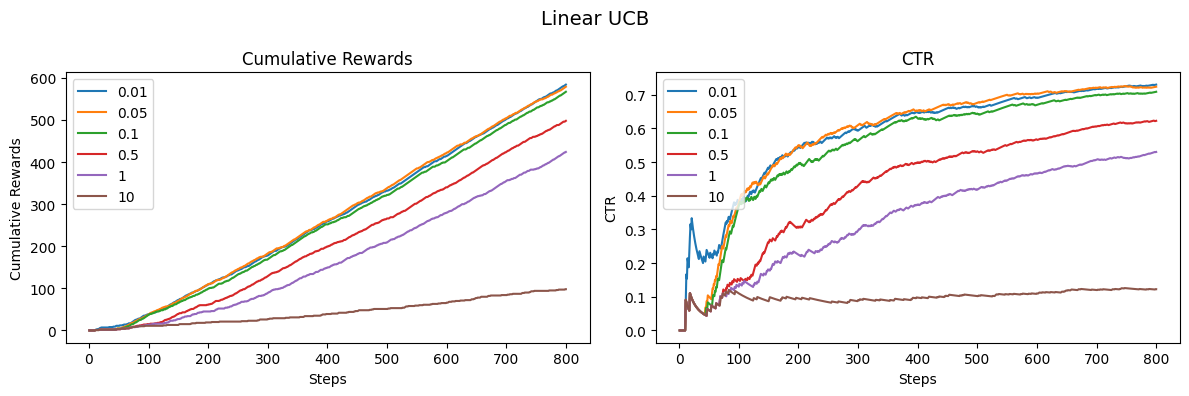

alpha: 0.01, avg reward: 0.73
alpha: 0.05, avg reward: 0.72375
alpha: 0.1, avg reward: 0.70875
alpha: 0.5, avg reward: 0.6225
alpha: 1, avg reward: 0.53
alpha: 10, avg reward: 0.1225


In [5]:
ctr = cumulative_rewards / np.arange(1, nsteps+1) # cumulative takeoff rate

plt.figure(figsize=(12, 4))
plt.suptitle("Linear UCB", fontsize=14)
plt.subplot(1, 2, 1)
plt.title("Cumulative Rewards")
plt.plot(np.arange(1, nsteps+1), cumulative_rewards.T)
plt.legend(alphas)
plt.xlabel("Steps")
plt.ylabel("Cumulative Rewards")
plt.subplot(1, 2, 2)
plt.title("CTR")
plt.plot(np.arange(1, nsteps+1), ctr.T)
plt.legend(alphas)
plt.xlabel("Steps")
plt.ylabel("CTR")
plt.tight_layout()
plt.show()

for i, alpha in enumerate(alphas):
    print("alpha: {}, avg reward: {}".format(alpha, avg_rewards[i]))

In [6]:
# Linear UCB (ucb-then-commit)

data = np.loadtxt(io.TextIOWrapper(io.BytesIO(requests.get('https://raw.githubusercontent.com/akhadangi/Multi-armed-Bandits/master/dataset.txt').content)))
arms = data[:,0].astype('int32') - 1 
rewards = data[:,1]

num_samples = len(arms)
num_arms = int(max(arms) + 1)

features = data[:,2:102].reshape(num_samples, num_arms, -1)  
dim_feats = int(features.shape[-1])

nsteps = 800
alphas = [0.01, 0.05, 0.1, 0.5, 1, 10]


avg_rewards = np.zeros(len(alphas))
cumulative_rewards = np.zeros((len(alphas), nsteps))
ctr = np.zeros((len(alphas), nsteps))

for i, alpha in enumerate(alphas):
    
    A = np.array([np.eye(dim_feats, dtype='float32') for a in range(num_arms)]) 
    b = np.array([np.zeros(dim_feats, dtype='float32') for a in range(num_arms)])
    model_rewards = []
    chosen_arms = []
    N = np.zeros(num_arms)
    N_threshold = np.floor(1 / 0.15)

    t = 0

    for arm, reward, feats in tqdm(zip(arms, rewards, features), total=num_samples):
        Ainv = np.linalg.inv(A)
        theta = np.array([_1 @ _2 for _1, _2 in zip(Ainv, b)])
        scores = [theta[a].T @ feats[a] + (alpha * np.sqrt(feats[a] @ Ainv[a] @ feats[a]) if N[a] <= N_threshold else 0) for a in range(num_arms)]

        pred_arm = npr.choice(np.where(scores == max(scores))[0])

        if pred_arm == arm:
            N[arm] += 1
            A[arm] += feats[arm].reshape(-1, 1) @ feats[arm].reshape(1, -1)
            b[arm] += reward * feats[arm]
            model_rewards.append(reward)
            cumulative_rewards[i, t] = np.sum(model_rewards)
            t += 1
            if t >= nsteps:
                break
            
    avg_rewards[i] = np.mean(model_rewards)
    print("alpha: {}, avg reward: {}".format(alpha, avg_rewards[i]))

 78%|███████▊  | 7820/10000 [00:06<00:01, 1252.92it/s]


alpha: 0.01, avg reward: 0.74375


 79%|███████▉  | 7885/10000 [00:04<00:01, 1866.00it/s]


alpha: 0.05, avg reward: 0.74125


 78%|███████▊  | 7777/10000 [00:05<00:01, 1549.64it/s]


alpha: 0.1, avg reward: 0.74125


 80%|███████▉  | 7966/10000 [00:05<00:01, 1467.28it/s]


alpha: 0.5, avg reward: 0.61125


 79%|███████▉  | 7932/10000 [00:07<00:01, 1103.79it/s]


alpha: 1, avg reward: 0.68125


 78%|███████▊  | 7807/10000 [00:05<00:01, 1332.49it/s]

alpha: 10, avg reward: 0.67375


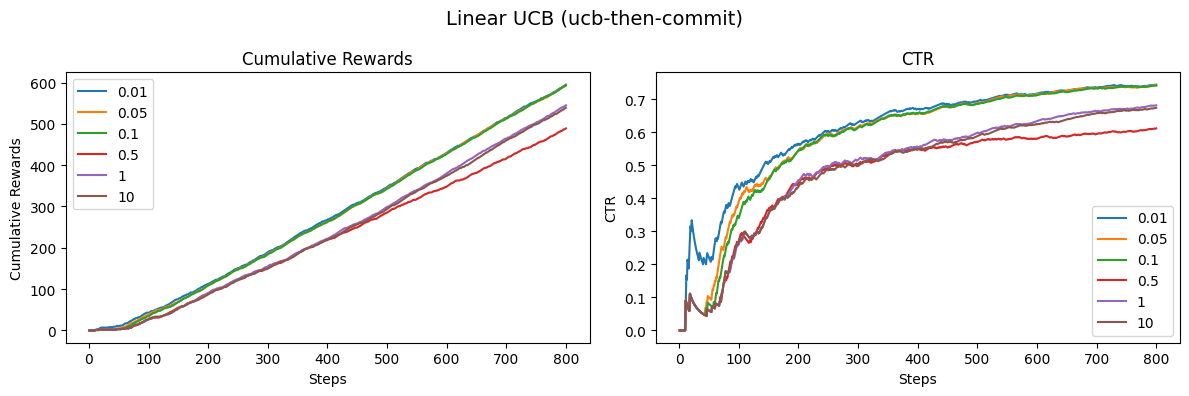

alpha: 0.01, avg reward: 0.74375
alpha: 0.05, avg reward: 0.74125
alpha: 0.1, avg reward: 0.74125
alpha: 0.5, avg reward: 0.61125
alpha: 1, avg reward: 0.68125
alpha: 10, avg reward: 0.67375


In [7]:
ctr = cumulative_rewards / np.arange(1, nsteps+1)

plt.figure(figsize=(12, 4))
plt.suptitle("Linear UCB (ucb-then-commit)", fontsize=14)
plt.subplot(1, 2, 1)
plt.title("Cumulative Rewards")
plt.plot(np.arange(1, nsteps+1), cumulative_rewards.T)
plt.legend(alphas)
plt.xlabel("Steps")
plt.ylabel("Cumulative Rewards")
plt.subplot(1, 2, 2)
plt.title("CTR")
plt.plot(np.arange(1, nsteps+1), ctr.T)
plt.legend(alphas)
plt.xlabel("Steps")
plt.ylabel("CTR")
plt.tight_layout()
plt.show()

for i, alpha in enumerate(alphas):
    print("alpha: {}, avg reward: {}".format(alpha, avg_rewards[i]))

In [8]:
data = np.loadtxt(io.TextIOWrapper(io.BytesIO(requests.get('https://raw.githubusercontent.com/akhadangi/Multi-armed-Bandits/master/dataset.txt').content)))
arms = data[:,0].astype('int32') - 1 
rewards = data[:,1]

num_samples = len(arms)
num_arms = int(max(arms) + 1)

features = data[:,2:102].reshape(num_samples, num_arms, -1)  
dim_feats = int(features.shape[-1])

nsteps = 800
alphas = [0.01, 0.05, 0.1, 0.5, 1, 10]

avg_rewards = np.zeros(len(alphas))
cumulative_rewards = np.zeros((len(alphas), nsteps))
ctr = np.zeros((len(alphas), nsteps))

for i, alpha in enumerate(alphas):
    
    A = np.array([np.eye(dim_feats, dtype='float32') for a in range(num_arms)]) 
    b = np.array([np.zeros(dim_feats, dtype='float32') for a in range(num_arms)])
    model_rewards = []
    chosen_arms = []
    t = 0
    distances = np.zeros(num_arms)
    N = np.zeros(num_arms)

    for arm, reward, feats in tqdm(zip(arms, rewards, features), total=num_samples):
        Ainv = np.linalg.inv(A)
        theta = np.array([_1 @ _2 for _1, _2 in zip(Ainv, b)])
        scores = np.array([theta[a].T @ feats[a] + alpha * np.sqrt(feats[a] @ Ainv[a] @ feats[a])
                for a in range(num_arms)])
        scores = scores / (1 + distances)
        pred_arm = np.argmax(scores)
        
        if pred_arm == arm:
            for a in range(num_arms):
                if a != arm:
                    dt = np.linalg.norm(theta[arm] - theta[a])
                    distances[a] += max(min(dt, 1), 0)
            
            A[arm] += feats[arm].reshape(-1, 1) @ feats[arm].reshape(1, -1)
            b[arm] += reward * feats[arm]
            model_rewards.append(reward)
            cumulative_rewards[i, t] = np.sum(model_rewards)
            t += 1
            if t >= nsteps:
                break

    avg_rewards[i] = np.mean(model_rewards)

 82%|████████▏ | 8242/10000 [00:05<00:01, 1502.49it/s]


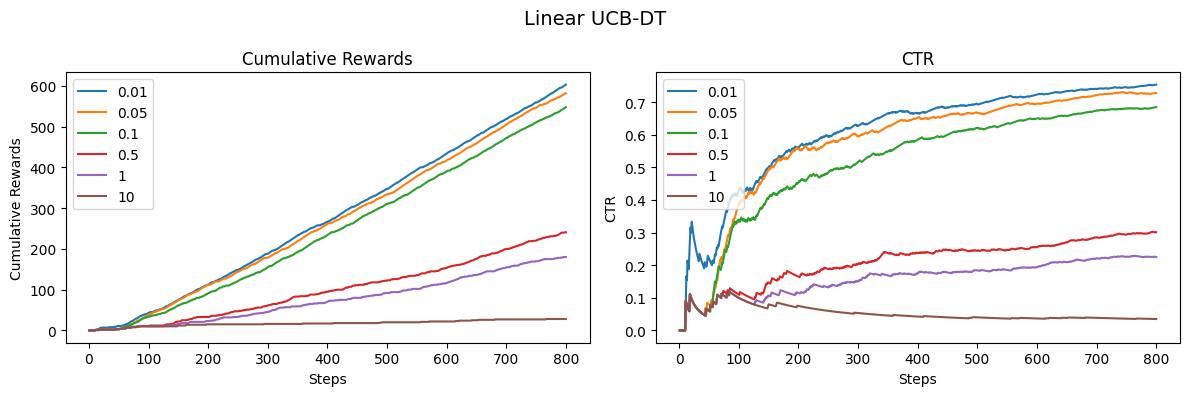

alpha: 0.01, avg reward: 0.75375
alpha: 0.05, avg reward: 0.7275
alpha: 0.1, avg reward: 0.685
alpha: 0.5, avg reward: 0.30125
alpha: 1, avg reward: 0.225
alpha: 10, avg reward: 0.035


In [9]:
ctr = cumulative_rewards / np.arange(1, nsteps+1)

plt.figure(figsize=(12, 4))
plt.suptitle("Linear UCB-DT", fontsize=14)
plt.subplot(1, 2, 1)
plt.title("Cumulative Rewards")
plt.plot(np.arange(1, nsteps+1), cumulative_rewards.T)
plt.legend(alphas)
plt.xlabel("Steps")
plt.ylabel("Cumulative Rewards")
plt.subplot(1, 2, 2)
plt.title("CTR")
plt.plot(np.arange(1, nsteps+1), ctr.T)
plt.legend(alphas)
plt.xlabel("Steps")
plt.ylabel("CTR")
plt.tight_layout()
plt.show()

for i, alpha in enumerate(alphas):
    print("alpha: {}, avg reward: {}".format(alpha, avg_rewards[i]))

In [10]:
(0.75375 - 0.73)/0.73 * 100

3.253424657534253

In [11]:
data = np.loadtxt(io.TextIOWrapper(io.BytesIO(requests.get('https://raw.githubusercontent.com/akhadangi/Multi-armed-Bandits/master/dataset.txt').content)))
arms = data[:,0].astype('int32') - 1 
rewards = data[:,1]

num_samples = len(arms)
num_arms = int(max(arms) + 1)

features = data[:,2:102].reshape(num_samples, num_arms, -1)  
dim_feats = int(features.shape[-1])

nsteps = 800
alphas = [0.01, 0.05, 0.1, 0.5, 1, 10]

avg_rewards = np.zeros(len(alphas))
cumulative_rewards = np.zeros((len(alphas), nsteps))
ctr = np.zeros((len(alphas), nsteps))

for i, alpha in enumerate(alphas):
    
    A = np.array([np.eye(dim_feats, dtype='float32') for a in range(num_arms)]) 
    b = np.array([np.zeros(dim_feats, dtype='float32') for a in range(num_arms)])
    model_rewards = []
    chosen_arms = []
    t = 0
    distances = np.zeros(num_arms)
    N = np.zeros(num_arms)

    for arm, reward, feats in tqdm(zip(arms, rewards, features), total=num_samples):
        Ainv = np.linalg.inv(A)
        theta = np.array([_1 @ _2 for _1, _2 in zip(Ainv, b)])
        scores = np.array([theta[a].T @ feats[a] + alpha * np.sqrt(feats[a] @ Ainv[a] @ feats[a])
                for a in range(num_arms)])
        scores = scores / (1 + distances)
        pred_arm = np.argmax(scores)
        
        if pred_arm == arm:
            for a in range(num_arms):
                if a != arm:
                    dt = np.linalg.norm(theta[arm].T @ feats[arm] - theta[a].T @ feats[a])
                    distances[a] += max(min(dt, 1), 0)
            
            A[arm] += feats[arm].reshape(-1, 1) @ feats[arm].reshape(1, -1)
            b[arm] += reward * feats[arm]
            model_rewards.append(reward)
            cumulative_rewards[i, t] = np.sum(model_rewards)
            t += 1
            if t >= nsteps:
                break

    avg_rewards[i] = np.mean(model_rewards)
    print("alpha: {}, avg reward: {}".format(alpha, avg_rewards[i]))

 77%|███████▋  | 7703/10000 [00:04<00:01, 1660.09it/s]


alpha: 0.01, avg reward: 0.7225


 79%|███████▉  | 7914/10000 [00:07<00:01, 1071.14it/s]


alpha: 0.05, avg reward: 0.7325


 78%|███████▊  | 7756/10000 [00:04<00:01, 1612.15it/s]


alpha: 0.1, avg reward: 0.705


 75%|███████▍  | 7485/10000 [00:05<00:01, 1459.06it/s]


alpha: 0.5, avg reward: 0.585


 78%|███████▊  | 7800/10000 [00:04<00:01, 1694.47it/s]


alpha: 1, avg reward: 0.4975


 81%|████████  | 8084/10000 [00:06<00:01, 1183.69it/s]

alpha: 10, avg reward: 0.035


In [12]:
data = np.loadtxt(io.TextIOWrapper(io.BytesIO(requests.get('https://raw.githubusercontent.com/akhadangi/Multi-armed-Bandits/master/dataset.txt').content)))
arms = data[:,0].astype('int32') - 1 
rewards = data[:,1]

num_samples = len(arms)
num_arms = int(max(arms) + 1)

features = data[:,2:102].reshape(num_samples, num_arms, -1)  
dim_feats = int(features.shape[-1])

nsteps = 800
alphas = [0.01, 0.05, 0.1, 0.5, 1, 10]

avg_rewards = np.zeros(len(alphas))
cumulative_rewards = np.zeros((len(alphas), nsteps))
ctr = np.zeros((len(alphas), nsteps))

for i, alpha in enumerate(alphas):
    
    A = np.array([np.eye(dim_feats, dtype='float32') for a in range(num_arms)]) 
    b = np.array([np.zeros(dim_feats, dtype='float32') for a in range(num_arms)])
    model_rewards = []
    chosen_arms = []
    t = 0
    distances = np.zeros(num_arms)
    N = np.zeros(num_arms)

    for arm, reward, feats in tqdm(zip(arms, rewards, features), total=num_samples):
        Ainv = np.linalg.inv(A)
        theta = np.array([_1 @ _2 for _1, _2 in zip(Ainv, b)])
        scores = np.array([theta[a].T @ feats[a] + alpha * np.sqrt(feats[a] @ Ainv[a] @ feats[a])
                for a in range(num_arms)])
        scores = scores / (1 + 0.1 * distances)
        pred_arm = np.argmax(scores)
        
        if pred_arm == arm:
            for a in range(num_arms):
                if a != arm:
                    dt = np.linalg.norm(theta[arm].T @ feats[arm] - theta[a].T @ feats[a])
                    distances[a] = max(min(dt, 1), 0)
            
            A[arm] += feats[arm].reshape(-1, 1) @ feats[arm].reshape(1, -1)
            b[arm] += reward * feats[arm]
            model_rewards.append(reward)
            cumulative_rewards[i, t] = np.sum(model_rewards)
            t += 1
            if t >= nsteps:
                break

    avg_rewards[i] = np.mean(model_rewards)
    print("alpha: {}, avg reward: {}".format(alpha, avg_rewards[i]))

 77%|███████▋  | 7703/10000 [00:06<00:01, 1206.45it/s]


alpha: 0.01, avg reward: 0.71875


 77%|███████▋  | 7733/10000 [00:06<00:01, 1228.83it/s]


alpha: 0.05, avg reward: 0.72375


 78%|███████▊  | 7756/10000 [00:04<00:01, 1747.24it/s]


alpha: 0.1, avg reward: 0.705


 76%|███████▋  | 7630/10000 [00:04<00:01, 1841.80it/s]


alpha: 0.5, avg reward: 0.6125


 78%|███████▊  | 7756/10000 [00:07<00:02, 1000.07it/s]


alpha: 1, avg reward: 0.525


 80%|███████▉  | 7966/10000 [00:04<00:01, 1599.30it/s]

alpha: 10, avg reward: 0.12125


### Linear UCB (Synthetic Datasets)

In [13]:
def generate_data(n, k, n_a, noise_std=0.1):
    D = np.random.random((n, k)) - 0.5  # generate data
    th = np.random.random((n_a, k)) - 0.5
    P = 10* D.dot(th.T)  # generate rewards
    optimal_rewards = np.max(P, axis=1)
    optimal_arms = np.argmax(P, axis=1)
    P += np.random.normal(0, noise_std, size=(n, n_a))
    return D, P, optimal_rewards, optimal_arms

def linear_ucb(D, P, alpha, n, k, n_a):
    A = np.array([np.eye(k) for _ in range(n_a)]) 
    b = np.array([np.zeros(k) for _ in range(n_a)])
    theta = np.array([np.zeros(k) for _ in range(n_a)]) 
    rewards = np.zeros(n)
    chosen_arms = np.zeros(n)

    for i in range(n):
        x = D[i]  # get the context
        for a in range(n_a):
            theta[a] = np.linalg.inv(A[a]).dot(b[a])  
        scores = [theta[a].T.dot(x) + alpha * np.sqrt(x.T.dot(np.linalg.inv(A[a])).dot(x)) for a in range(n_a)]
        chosen_arm = np.argmax(scores)  
        chosen_arms[i] = chosen_arm
        reward = P[i, chosen_arm]  # get the reward
        rewards[i] = reward  # update rewards
        A[chosen_arm] += np.outer(x, x) 
        b[chosen_arm] += reward * x 
    return rewards, chosen_arms

def distance_LUCB(D, P, alpha, n, k, n_a, gamma=0.1):
    A = np.array([np.eye(k) for _ in range(n_a)])
    b = np.array([np.zeros(k) for _ in range(n_a)])
    theta = np.array([np.zeros(k) for _ in range(n_a)])
    rewards = np.zeros(n) 
    chosen_arms = np.zeros(n)
    for i in range(n):
        x = D[i] 
        for a in range(n_a):
            theta[a] = np.linalg.inv(A[a]).dot(b[a]) 
        ucb = [theta[a].T.dot(x) + alpha * np.sqrt(x.T.dot(np.linalg.inv(A[a])).dot(x)) for a in range(n_a)]
        chosen_arm = np.argmax(ucb)
        chosen_arms[i] = chosen_arm
        reward = P[i, chosen_arm]  
        rewards[i] = reward  
        
        # compute the distance as the difference between UCB and expected reward
        distance = ucb[chosen_arm] - theta[chosen_arm].T.dot(x)
        A[chosen_arm] += (1 + gamma * distance) * np.outer(x, x)
        b[chosen_arm] += reward * x

    return rewards, chosen_arms

def linear_ucb_then_commit(D, P, alpha, n, k, n_a, gamma=0.02):
    A = np.array([np.eye(k) for _ in range(n_a)])
    b = np.array([np.zeros(k) for _ in range(n_a)])
    theta = np.array([np.zeros(k) for _ in range(n_a)])  
    rewards = np.zeros(n)  
    chosen_arms = np.zeros(n)  
    N = np.zeros(n_a)  
    N_threshold = np.floor(1 / gamma)

    for i in range(n):
        x = D[i]  
        for a in range(n_a):
            theta[a] = np.linalg.inv(A[a]).dot(b[a])  

        scores = [theta[a].T.dot(x) + (alpha * np.sqrt(x.T.dot(np.linalg.inv(A[a])).dot(x)) if N[a] <= N_threshold else 0) for a in range(n_a)]
        chosen_arm = np.argmax(scores)  
        chosen_arms[i] = chosen_arm
        reward = P[i, chosen_arm]  
        rewards[i] = reward  
        A[chosen_arm] += np.outer(x, x)  
        b[chosen_arm] += reward * x  
        N[chosen_arm] += 1  
    return rewards, chosen_arms

#### Alpha grid search (Linear UCB)

In [15]:
num_simulations = 5
n = 5000
k = 20
n_a = 10

alphas = [0.01, 0.1, 1, 10, 20, 50, 100]

cum_rewards = np.zeros((len(alphas), num_simulations, n))
ctr = np.zeros((len(alphas), num_simulations, n))
regret = np.zeros((len(alphas), num_simulations, n))

for i, alpha in enumerate(alphas):
    for j in range(num_simulations):
        np.random.seed(j)
        D, P, optimal_rewards, optimal_arms = generate_data(n, k, n_a)
        rewards, chosen_arms = linear_ucb(D, P, alpha, n, k, n_a)
        
        cum_rewards[i, j] = np.cumsum(rewards)
        ctr[i, j] = np.cumsum(rewards) / np.arange(1, n + 1)
        regret[i, j] = np.cumsum(optimal_rewards - rewards)

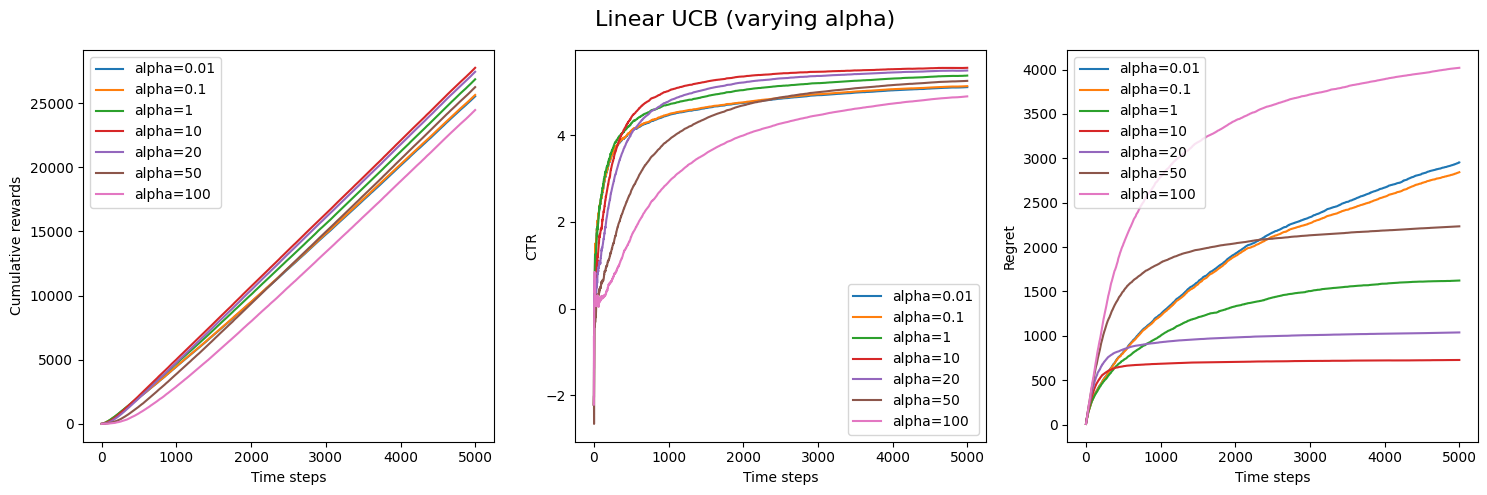

In [16]:
import matplotlib.pyplot as plt

avg_rewards = cum_rewards.mean(axis=1)
avg_ctr = ctr.mean(axis=1)
avg_regret = regret.mean(axis=1)

plt.figure(figsize=(15, 5))
plt.suptitle('Linear UCB (varying alpha)', fontsize=16)
plt.subplot(1, 3, 1)
for i, alpha in enumerate(alphas):
    plt.plot(avg_rewards[i], label=f'alpha={alpha}')
plt.xlabel('Time steps')
plt.ylabel('Cumulative rewards')
plt.legend()

plt.subplot(1, 3, 2)
for i, alpha in enumerate(alphas):
    plt.plot(avg_ctr[i], label=f'alpha={alpha}')
plt.xlabel('Time steps')
plt.ylabel('CTR')
plt.legend()

plt.subplot(1, 3, 3)
for i, alpha in enumerate(alphas):
    plt.plot(avg_regret[i], label=f'alpha={alpha}')
plt.xlabel('Time steps')
plt.ylabel('Regret')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
print('cum_rewards', avg_rewards[3][-1])
print('ctr', avg_ctr[3][-1])
print('regret', avg_regret[3][-1])

cum_rewards 27756.955545707944
ctr 5.551391109141588
regret 727.6441486426183


### Linear UCB-then-commit

#### Alpha grid search

In [19]:
num_simulations = 5
n = 5000
k = 20
n_a = 10

alphas = [0.01, 0.1, 1, 10, 20, 50, 100]

cum_rewards_ucbc = np.zeros((len(alphas), num_simulations, n))
ctr_ucbc = np.zeros((len(alphas), num_simulations, n))
regret_ucbc = np.zeros((len(alphas), num_simulations, n))

for i, alpha in enumerate(alphas):
    for j in range(num_simulations):
        np.random.seed(j)
        D, P, optimal_rewards, optimal_arms = generate_data(n, k, n_a)
        rewards, chosen_arms = linear_ucb_then_commit(D, P, alpha, n, k, n_a, gamma=0.06)
        
        cum_rewards_ucbc[i, j] = np.cumsum(rewards)
        ctr_ucbc[i, j] = np.cumsum(rewards) / np.arange(1, n + 1)
        regret_ucbc[i, j] = np.cumsum(optimal_rewards - rewards)

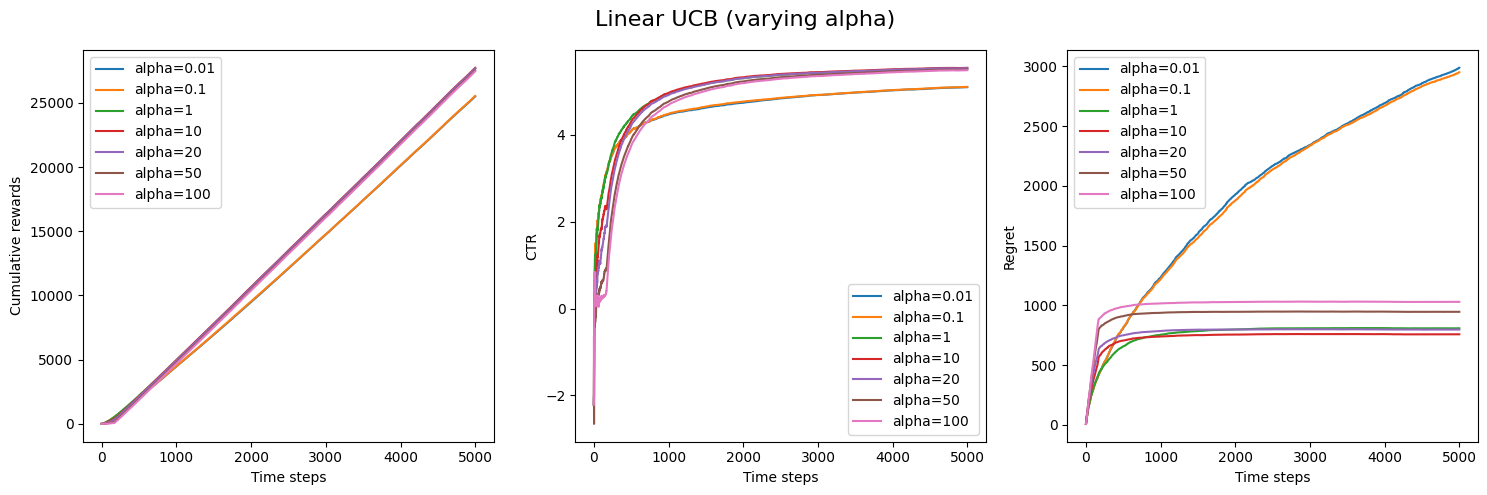

In [20]:
import matplotlib.pyplot as plt

avg_rewards_ucbc = cum_rewards_ucbc.mean(axis=1)
avg_ctr_ucbc = ctr_ucbc.mean(axis=1)
avg_regret_ucbc = regret_ucbc.mean(axis=1)

plt.figure(figsize=(15, 5))
plt.suptitle('Linear UCB then Commit (varying alpha)', fontsize=16)
plt.subplot(1, 3, 1)
for i, alpha in enumerate(alphas):
    plt.plot(avg_rewards_ucbc[i], label=f'alpha={alpha}')
plt.xlabel('Time steps')
plt.ylabel('Cumulative rewards')
plt.legend()

plt.subplot(1, 3, 2)
for i, alpha in enumerate(alphas):
    plt.plot(avg_ctr_ucbc[i], label=f'alpha={alpha}')
plt.xlabel('Time steps')
plt.ylabel('CTR')
plt.legend()

plt.subplot(1, 3, 3)
for i, alpha in enumerate(alphas):
    plt.plot(avg_regret_ucbc[i], label=f'alpha={alpha}')
plt.xlabel('Time steps')
plt.ylabel('Regret')
plt.legend()

plt.tight_layout()
plt.show()

#### Gamma grid search

In [21]:
num_simulations = 5
n = 10000
k = 20
n_a = 10

alpha = 10.0
gamma = [0.5, 0.1, 0.08, 0.06, 0.04, 0.008]

cum_rewards = np.zeros((len(gamma), num_simulations, n))
cum_rewards_ucbc = np.zeros((len(gamma), num_simulations, n))

ctr = np.zeros((len(gamma), num_simulations, n))
ctr_ucbc = np.zeros((len(gamma), num_simulations, n))

regret = np.zeros((len(gamma), num_simulations, n))
regret_ucbc = np.zeros((len(gamma), num_simulations, n))

optimal_regret = np.zeros((len(gamma), num_simulations, n))

for i, g in enumerate(gamma):
    for j in range(num_simulations):
        np.random.seed(j)
        D, P, optimal_rewards, optimal_arms = generate_data(n, k, n_a)
        rewards, chosen_arms = linear_ucb(D, P, alpha, n, k, n_a)
        rewards_ucbc, chosen_arms_ucbc = linear_ucb_then_commit(D, P, alpha, n, k, n_a, gamma=g)
        
        cum_rewards[i, j] = np.cumsum(rewards)
        cum_rewards_ucbc[i, j] = np.cumsum(rewards_ucbc)

        ctr[i, j] = np.cumsum(rewards) / np.arange(1, n + 1)
        ctr_ucbc[i, j] = np.cumsum(rewards_ucbc) / np.arange(1, n + 1)

        regret[i, j] = np.cumsum(optimal_rewards - rewards)
        regret_ucbc[i, j] = np.cumsum(optimal_rewards - rewards_ucbc)

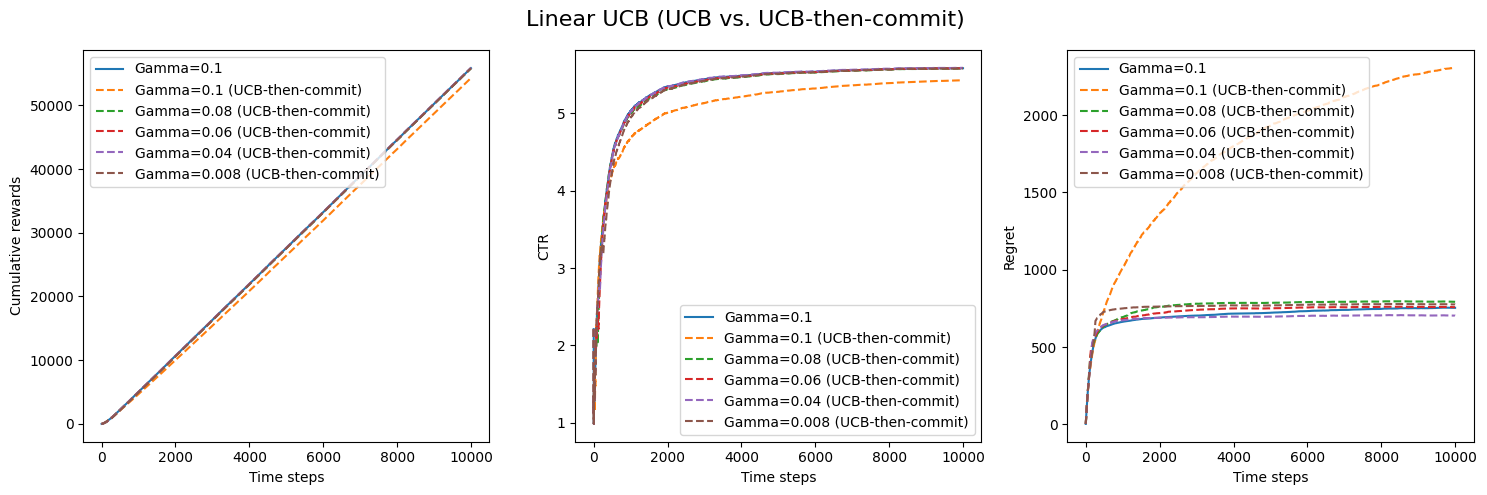

In [22]:
import matplotlib.pyplot as plt

avg_rewards = cum_rewards.mean(axis=1)
avg_rewards_ucbc = cum_rewards_ucbc.mean(axis=1)

avg_ctr = ctr.mean(axis=1)
avg_ctr_ucbc = ctr_ucbc.mean(axis=1)

avg_regret = regret.mean(axis=1)
avg_regret_ucbc = regret_ucbc.mean(axis=1)

plt.figure(figsize=(15, 5))
gamma = [0.1, 0.08, 0.06, 0.04, 0.008]

plt.subplot(1, 3, 1)
plt.suptitle('Linear UCB (UCB vs. UCB-then-commit)', fontsize=16)
for i, g in enumerate(gamma):
    if i == 0:
        plt.plot(avg_rewards[i], label=f'Gamma={g}')
    plt.plot(avg_rewards_ucbc[i], label=f'Gamma={g} (UCB-then-commit)', linestyle='dashed')
plt.xlabel('Time steps')
plt.ylabel('Cumulative rewards')
plt.legend()

plt.subplot(1, 3, 2)
for i, g in enumerate(gamma):
    if i == 0:
        plt.plot(avg_ctr[i], label=f'Gamma={g}')
    plt.plot(avg_ctr_ucbc[i], label=f'Gamma={g} (UCB-then-commit)', linestyle='dashed')
plt.xlabel('Time steps')
plt.ylabel('CTR')
plt.legend()

plt.subplot(1, 3, 3)
for i, g in enumerate(gamma):
    if i == 0:
        plt.plot(avg_regret[i], label=f'Gamma={g}')
    plt.plot(avg_regret_ucbc[i], label=f'Gamma={g} (UCB-then-commit)', linestyle='dashed')
plt.xlabel('Time steps')
plt.ylabel('Regret')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
print('Mean rewards (UCB):', avg_rewards[0][-1])
print('Mean rewards (UCB-then-commit):', avg_rewards_ucbc[3][-1])

print(np.abs(avg_rewards[0][-1] - avg_rewards_ucbc[3][-1]))

Mean rewards (UCB): 55836.822340629835
Mean rewards (UCB-then-commit): 55887.349647010225
50.527306380390655


### Linear UCB Distance-Adjusted

In [24]:
def distance_LUCB(D, P, alpha, n, k, n_a, gamma=0.1):
    A = np.array([np.eye(k) for _ in range(n_a)])  
    b = np.array([np.zeros(k) for _ in range(n_a)])  
    theta = np.array([np.zeros(k) for _ in range(n_a)])  
    rewards = np.zeros(n)  
    chosen_arms = np.zeros(n)  
    for i in range(n):
        x = D[i]  # get the context
        for a in range(n_a):
            theta[a] = np.linalg.inv(A[a]).dot(b[a])  
        ucb = [theta[a].T.dot(x) + alpha * np.sqrt(x.T.dot(np.linalg.inv(A[a])).dot(x)) for a in range(n_a)]
        chosen_arm = np.argmax(ucb)  
        chosen_arms[i] = chosen_arm
        reward = P[i, chosen_arm]  
        rewards[i] = reward  
        
        # compute the distance as the difference between UCB and expected reward
        distance = ucb[chosen_arm] - theta[chosen_arm].T.dot(x)
        A[chosen_arm] += (1 + gamma * distance) * np.outer(x, x)
        b[chosen_arm] += reward * x

    return rewards, chosen_arms

#### Alpha grid search


In [25]:
num_simulations = 5
n = 5000
k = 20
n_a = 10

alphas = [0.01, 0.1, 1, 10, 20, 50, 100]

cum_rewards_dist = np.zeros((len(alphas), num_simulations, n))
ctr_dist = np.zeros((len(alphas), num_simulations, n))
regret_dist = np.zeros((len(alphas), num_simulations, n))

for i, alpha in enumerate(alphas):
    for j in range(num_simulations):
        np.random.seed(j)
        D, P, optimal_rewards, optimal_arms = generate_data(n, k, n_a)
        rewards, chosen_arms = distance_LUCB(D, P, alpha, n, k, n_a, gamma=0.06)
        
        cum_rewards_dist[i, j] = np.cumsum(rewards)
        ctr_dist[i, j] = np.cumsum(rewards) / np.arange(1, n + 1)
        regret_dist[i, j] = np.cumsum(optimal_rewards - rewards)

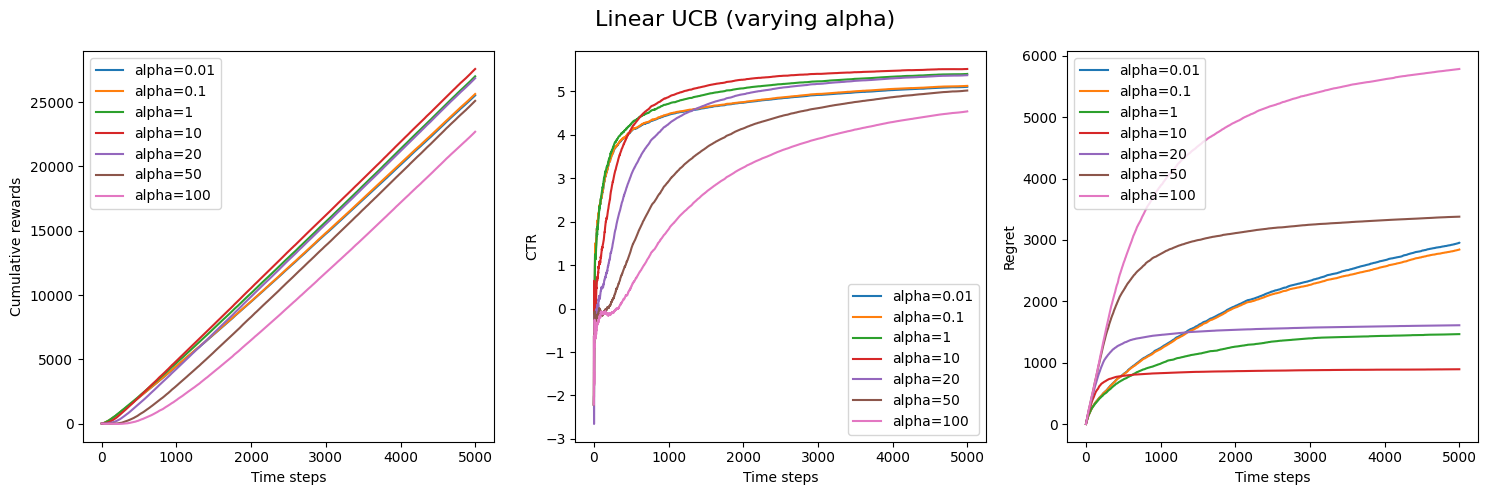

In [26]:
import matplotlib.pyplot as plt

# Compute averages over simulations
avg_rewards_dist = cum_rewards_dist.mean(axis=1)
avg_ctr_dist = ctr_dist.mean(axis=1)
avg_regret_dist = regret_dist.mean(axis=1)

# Generate plots
plt.figure(figsize=(15, 5))
plt.suptitle('Linear UCB Distance Adjusted (varying alpha)', fontsize=16)
plt.subplot(1, 3, 1)
for i, alpha in enumerate(alphas):
    plt.plot(avg_rewards_dist[i], label=f'alpha={alpha}')
plt.xlabel('Time steps')
plt.ylabel('Cumulative rewards')
plt.legend()

plt.subplot(1, 3, 2)
for i, alpha in enumerate(alphas):
    plt.plot(avg_ctr_dist[i], label=f'alpha={alpha}')
plt.xlabel('Time steps')
plt.ylabel('CTR')
plt.legend()

plt.subplot(1, 3, 3)
for i, alpha in enumerate(alphas):
    plt.plot(avg_regret_dist[i], label=f'alpha={alpha}')
plt.xlabel('Time steps')
plt.ylabel('Regret')
plt.legend()

plt.tight_layout()
plt.show()

#### Linear UCB Distance Adjusted gamma search

In [28]:
num_simulations = 5
n = 10000
k = 20
n_a = 5

alpha = 10.0
gamma = [0.5, 0.1, 0.05, 0.008]

cum_rewards = np.zeros((len(gamma), num_simulations, n))
cum_rewards_dist_adjusted = np.zeros((len(gamma), num_simulations, n))

ctr = np.zeros((len(gamma), num_simulations, n))
ctr_dist_adjusted = np.zeros((len(gamma), num_simulations, n))

regret = np.zeros((len(gamma), num_simulations, n))
regret_dist_adjusted = np.zeros((len(gamma), num_simulations, n))

optimal_regret = np.zeros((len(gamma), num_simulations, n))

for i, g in enumerate(gamma):
    for j in range(num_simulations):
        np.random.seed(j)
        D, P, optimal_rewards, optimal_arms = generate_data(n, k, n_a)
        rewards, chosen_arms = linear_ucb(D, P, alpha, n, k, n_a)
        rewards_dist_adjusted, chosen_arms_dist_adjusted = distance_LUCB(D, P, alpha, n, k, n_a, gamma=g)
        
        cum_rewards[i, j] = np.cumsum(rewards)
        cum_rewards_dist_adjusted[i, j] = np.cumsum(rewards_dist_adjusted)

        ctr[i, j] = np.cumsum(rewards) / np.arange(1, n + 1)
        ctr_dist_adjusted[i, j] = np.cumsum(rewards_dist_adjusted) / np.arange(1, n + 1)

        regret[i, j] = np.cumsum(optimal_rewards - rewards)
        regret_dist_adjusted[i, j] = np.cumsum(optimal_rewards - rewards_dist_adjusted)

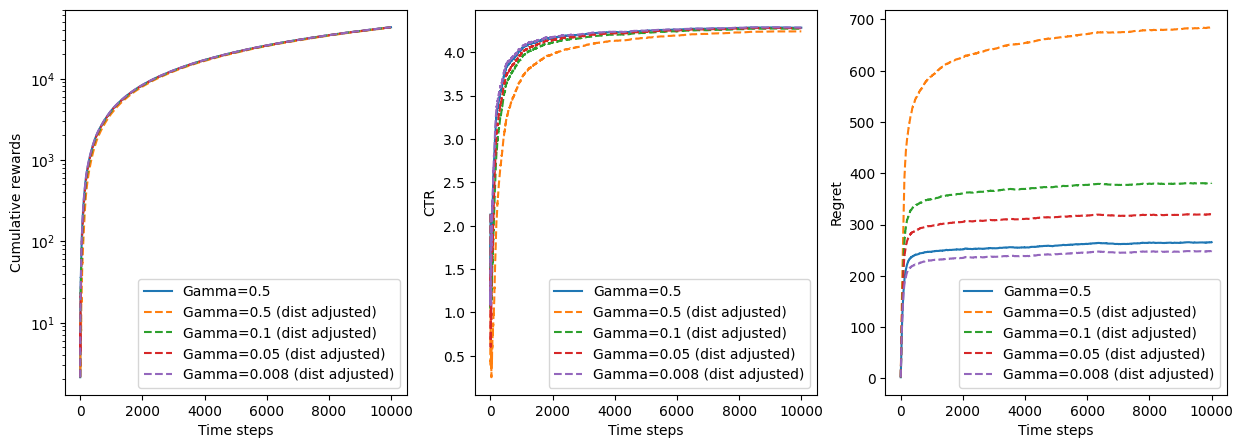

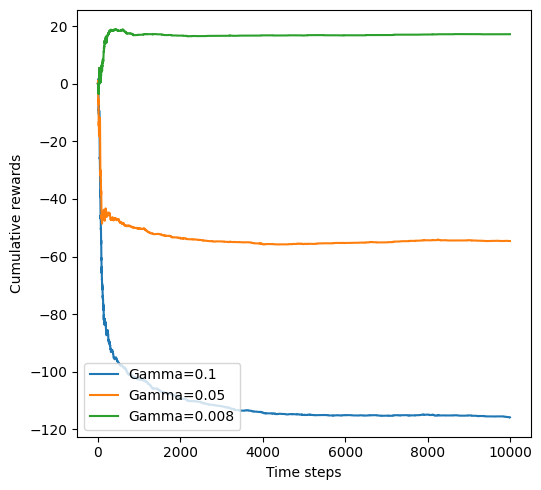

In [31]:
import matplotlib.pyplot as plt

# Compute averages over simulations
avg_rewards = cum_rewards.mean(axis=1)
avg_rewards_dist_adjusted = cum_rewards_dist_adjusted.mean(axis=1)

avg_ctr = ctr.mean(axis=1)
avg_ctr_dist_adjusted = ctr_dist_adjusted.mean(axis=1)

avg_regret = regret.mean(axis=1)
avg_regret_dist_adjusted = regret_dist_adjusted.mean(axis=1)

plt.figure(figsize=(15, 5))
# gamma = [1.0, 0.5, 0.1, 0.08, 0.06, 0.04, 0.008]
gamma = [0.5, 0.1, 0.05, 0.008]

plt.subplot(1, 3, 1)
for i, g in enumerate(gamma):
    if i == 0:
        plt.plot(avg_rewards[i], label=f'Gamma={g}')
    plt.plot(avg_rewards_dist_adjusted[i], label=f'Gamma={g} (dist adjusted)', linestyle='dashed')
plt.xlabel('Time steps')
plt.ylabel('Cumulative rewards')
plt.yscale('log')
plt.legend()

plt.subplot(1, 3, 2)
for i, g in enumerate(gamma):
    if i == 0:
        plt.plot(avg_ctr[i], label=f'Gamma={g}')
    plt.plot(avg_ctr_dist_adjusted[i], label=f'Gamma={g} (dist adjusted)', linestyle='dashed')
plt.xlabel('Time steps')
plt.ylabel('CTR')
plt.legend()

plt.subplot(1, 3, 3)
for i, g in enumerate(gamma):
    if i == 0:
        plt.plot(avg_regret[i], label=f'Gamma={g}')
    plt.plot(avg_regret_dist_adjusted[i], label=f'Gamma={g} (dist adjusted)', linestyle='dashed')
plt.xlabel('Time steps')
plt.ylabel('Regret')
plt.legend()


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
for i, g in enumerate(gamma):
    if i != 0:
        plt.plot(avg_rewards_dist_adjusted[i] - avg_rewards[i], label=f'Gamma={g}')
plt.xlabel('Time steps')
plt.ylabel('Cumulative rewards')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
print('Linear UCB Expected Reward', avg_rewards[0][-1])
print('Linear UCB (Dist-adjusted) Expected Reward', avg_rewards_dist_adjusted[3][-1])

Linear UCB Expected Reward 42834.203114885895
Linear UCB (Dist-adjusted) Expected Reward 42851.3699056234
